# CNN+LSTM 전력 수요 예측 

### <목차>

### <화면 가로 확장>

In [1]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import time
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from scipy.stats import norm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.wrappers import TimeDistributed
import keras

In [9]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

폴더 생성 완료.


### <GPU 확인>

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 데이터 로드

In [4]:
Data_13=pd.read_csv('./Combined_Data_New/2013_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_14=pd.read_csv('./Combined_Data_New/2014_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_15=pd.read_csv('./Combined_Data_New/2015_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_16=pd.read_csv('./Combined_Data_New/2016_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')

In [5]:
Data_4Y = pd.read_csv('./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16.csv', encoding='cp949')
Data_4Y.info()

FileNotFoundError: [Errno 2] No such file or directory: './Combined_Data_New/House1_Ch1_Combined_Data_New_13-16.csv'

In [7]:
Data_4Y

,Unnamed: 0,Year-Month-Date,Time,Holiday,Watt,Temp('C),Humidity(%),CPI
0,0,2013-01-01,[ 00:00 ],1,522,10.0,87.000,2.7
1,1,2013-01-01,[ 00:01 ],1,558,10.0,86.833,2.7
2,2,2013-01-01,[ 00:02 ],1,537,10.0,86.667,2.7
3,3,2013-01-01,[ 00:03 ],1,525,10.0,86.500,2.7
4,4,2013-01-01,[ 00:04 ],1,539,10.0,86.333,2.7
...,...,...,...,...,...,...,...,...
2102395,2102395,2016-12-31,[ 23:55 ],1,456,8.0,88.000,1.6
2102396,2102396,2016-12-31,[ 23:56 ],1,460,8.0,87.800,1.6
2102397,2102397,2016-12-31,[ 23:57 ],1,458,8.0,87.600,1.6
2102398,2102398,2016-12-31,[ 23:58 ],1,424,8.0,87.400,1.6


### 이상치 처리

#### 전체 데이터(4년)의 이상치 판별 기준 추출

In [8]:
def get_outlier(df=None, column=None, weight=None):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    
    return outlier_index_low, outlier_index_high, quantile_25, quantile_50, quantile_75, lowest_val, highest_val

In [9]:
def get_list_outlier(df=None, column=None, low=None, high=None):
    outlier_index_low = df[column][df[column] < low].index
    outlier_index_high = df[column][df[column] > high].index
    
    return outlier_index_low, outlier_index_high

In [10]:
WEIGHT=3
Low_list=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[0]
High_list=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[1]
print('Low Outlier ==>> {}\n'.format(Low_list))
print('High Outlier ==>> {}\n'.format(High_list))

print("Ratio of High Outlier ==>> {} %\n".format(round(len(High_list)/len(Data_4Y),4)*100))

Value_25=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[2]
Value_50=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[3]
Value_75=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[4]
print('25%_Value ==>> {}\n'.format(Value_25))
print('50%_Value ==>> {}\n'.format(Value_50))
print('75%_Value ==>> {}\n'.format(Value_75))

Lowest_Line=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[5]
Highest_Line=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[6]
print('Lowest Line ==>> {}\n'.format(Lowest_Line))
print('Highest Line ==>> {}\n'.format(Highest_Line))

Low Outlier ==>> Int64Index([], dtype='int64')

High Outlier ==>> Int64Index([     27,      28,      55,      56,      57,      58,      59,
                 60,      61,      62,
            ...
            2101861, 2102205, 2102206, 2102207, 2102208, 2102209, 2102389,
            2102390, 2102391, 2102392],
           dtype='int64', length=123886)

Ratio of High Outlier ==>> 5.89 %

25%_Value ==>> 196.0

50%_Value ==>> 262.0

75%_Value ==>> 418.0

Lowest Line ==>> -470.0

Highest Line ==>> 1084.0



In [11]:
High_list_13=get_list_outlier(df=Data_13, column="Watt", low=Lowest_Line, high=Highest_Line)[1]
High_list_14=get_list_outlier(df=Data_14, column="Watt", low=Lowest_Line, high=Highest_Line)[1]
High_list_15=get_list_outlier(df=Data_15, column="Watt", low=Lowest_Line, high=Highest_Line)[1]

print(len(High_list_13), len(High_list_14), len(High_list_15))

28187 34959 35088


In [12]:
for i in range(len(High_list_13)):
    Data_13['Watt'][High_list_13[i]] = Highest_Line
    
for i in range(len(High_list_14)):
    Data_14['Watt'][High_list_14[i]] = Highest_Line
    
for i in range(len(High_list_15)):
    Data_15['Watt'][High_list_15[i]] = Highest_Line

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_6940/2729860078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_13['Watt'][High_list_13[i]] = Highest_Line
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_6940/2729860078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_14['Watt'][High_list_14[i]] = Highest_Line
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_6940/2729860078.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
High_list_13=get_list_outlier(df=Data_13, column="Watt", low=Lowest_Line, high=Highest_Line)[1]
High_list_14=get_list_outlier(df=Data_14, column="Watt", low=Lowest_Line, high=Highest_Line)[1]
High_list_15=get_list_outlier(df=Data_15, column="Watt", low=Lowest_Line, high=Highest_Line)[1]

print(len(High_list_13), len(High_list_14), len(High_list_15))

0 0 0


In [18]:
df_4Y = pd.DataFrame()
df_4Y = pd.concat([df_4Y, Data_13])
df_4Y = pd.concat([df_4Y, Data_14])
df_4Y = pd.concat([df_4Y, Data_15])
df_4Y = pd.concat([df_4Y, Data_16])
    
df_4Y = df_4Y.drop([df_4Y.columns[0]], axis=1)
df_4Y = df_4Y.reset_index(drop=True)
df_4Y.to_csv("./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Edited.csv", encoding='cp949')
print("Done!")

Done!


### SPSS 사용을 위한 Excel 파일 저장

In [10]:
"""
Data_SPSS = Data_4Y[["Year-Month-Date", "Time", "Holiday", "Watt", "Temp('C)", "Humidity(%)", "CPI"]]
Data_SPSS.to_excel('./Combined_Data/Data_SPSS.xlsx')
"""

### 연관성 검사 분석

In [11]:
# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)

Correlation=stats.pearsonr(Data_4Y['Holiday'], Data_4Y['Watt'])
print('< Holiday - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y["Temp('C)"], Data_4Y['Humidity(%)'])
print('< Temp - Humidity >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y["Temp('C)"], Data_4Y['Watt'])
print('< Temp - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y['Humidity(%)'], Data_4Y['Watt'])
print('< Humidity - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.60f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y['CPI'], Data_4Y['Watt'])
print('< CPI - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

< Holiday - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000011102425943733486539351013686

< Temp - Humidity >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000

< Temp - Watt >
P-value >> 0.234
Total P-value >> 0.2337249124482020101734036643392755649984

< Humidity - Watt >
P-value >> 0.000
Total P-value >> 0.000000000000000000000000000000000000000025836435244788723101

< CPI - Watt >
P-value >> 0.000
Total P-value >> 0.0000000666305100832188352636214719905416



In [3]:
Data_4Y_Edited = pd.read_csv("./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Edited.csv", encoding='cp949')

### 4. 데이터 정규화

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [4]:
# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_4Y_Edited.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
#scaler = RobustScaler()

scale_cols = ["Holiday", "Watt", "Temp('C)", "Humidity(%)", "CPI"]
Data_4Y_scaled = scaler.fit_transform(Data_4Y_Edited[scale_cols])
Data_4Y_scaled = pd.DataFrame(Data_4Y_scaled)
Data_4Y_scaled.columns = scale_cols

Data_4Y_scaled.insert(2, "Watt2", Data_4Y_scaled["Watt"])
Data_4Y_scaled=Data_4Y_scaled[["Holiday","Temp('C)", "CPI", "Humidity(%)", "Watt", "Watt2"]]

"""
Data_MinMax_SPSS=Data_4Y_scaled[["Holiday","Temp('C)", "Humidity(%)", "CPI", "Watt"]]
Data_MinMax_SPSS.to_excel('./Combined_Data/Data_MinMax_SPSS.xlsx')
"""

'\nData_MinMax_SPSS=Data_4Y_scaled[["Holiday","Temp(\'C)", "Humidity(%)", "CPI", "Watt"]]\nData_MinMax_SPSS.to_excel(\'./Combined_Data/Data_MinMax_SPSS.xlsx\')\n'

#### 정규분포 시각화

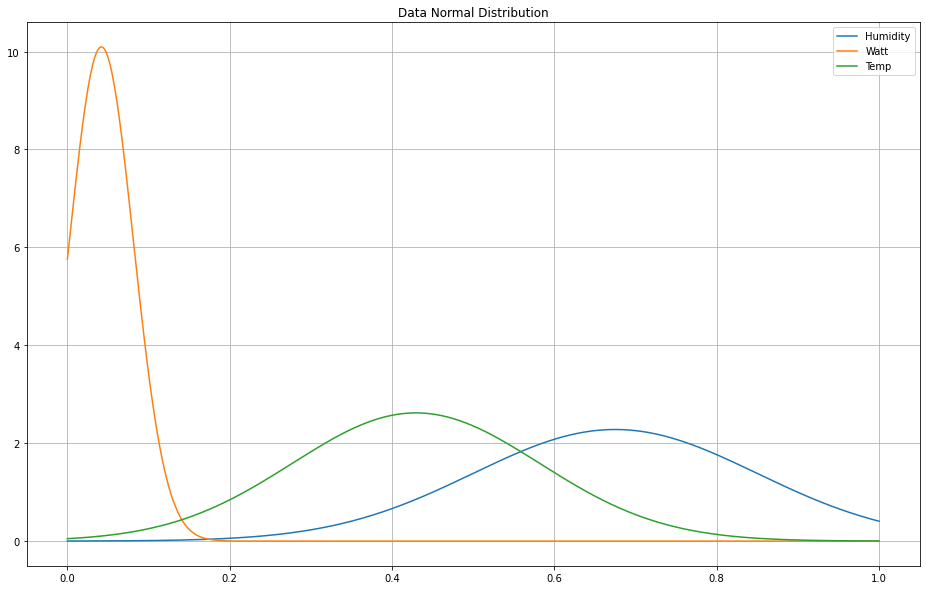

In [5]:
plt.figure(figsize=(16,10))
plt.grid()
plt.title("Data Normal Distribution")
#plt.plot(np.sort(Data_4Y_scaled["Holiday"]), norm.pdf(np.sort(Data_4Y_scaled["Holiday"]), np.mean(Data_4Y_scaled["Holiday"]), np.std(Data_4Y_scaled["Holiday"])), label="Holiday")
plt.plot(np.sort(Data_4Y_scaled["Humidity(%)"]), norm.pdf(np.sort(Data_4Y_scaled["Humidity(%)"]), np.mean(Data_4Y_scaled["Humidity(%)"]), np.std(Data_4Y_scaled["Humidity(%)"])), label="Humidity")
plt.plot(np.sort(Data_4Y_scaled["Watt"]), norm.pdf(np.sort(Data_4Y_scaled["Watt"]), np.mean(Data_4Y_scaled["Watt"]), np.std(Data_4Y_scaled["Watt"])), label="Watt")
plt.plot(np.sort(Data_4Y_scaled["Temp('C)"]), norm.pdf(np.sort(Data_4Y_scaled["Temp('C)"]), np.mean(Data_4Y_scaled["Temp('C)"]), np.std(Data_4Y_scaled["Temp('C)"])), label="Temp")
plt.legend()
plt.savefig('./Result/Data_Normal_Distribution.png')
plt.show()

### 7. 데이터셋 편집

In [37]:
TEST_SIZE = 525600 #1년치를 테스트셋으로 사용
WINDOW_SIZE = 1 #얼마 동안의 과거 기반의 데이터로 다음값을 예측할 것인지 설정. 1분단위 데이터이니 모아서 1시간 단위로 예측
BATCH_SIZE = 128 #128
VAL_DAYS = 525600

In [38]:
# train과 test셋 분할
learning = Data_4Y_scaled[:-TEST_SIZE] # 학습에 쓰이는 전체 데이터
VAL_RATIO=VAL_DAYS/len(learning)
VAL_SIZE = int(len(learning)*VAL_RATIO)
TRAIN = learning[:-VAL_SIZE]
VAL = learning[-VAL_SIZE:]
TEST = Data_4Y_scaled[-(TEST_SIZE+WINDOW_SIZE):]
print(len(TRAIN), len(VAL), len(TEST))

1051200 525600 525601


In [39]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [40]:
train_data = windowed_dataset(TRAIN, WINDOW_SIZE, BATCH_SIZE, False) 
valid_data = windowed_dataset(VAL, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(TEST, WINDOW_SIZE, BATCH_SIZE, False)

### 8. 딥러닝 모델

In [41]:
LeakyReLU=tf.keras.layers.LeakyReLU(alpha=1.0)

model = Sequential([
    Conv1D(filters=64, kernel_size=9, padding="same", input_shape=[WINDOW_SIZE, TRAIN.shape[1]]),
    Bidirectional(LSTM(8, activation=LeakyReLU, return_sequences=True), merge_mode='concat'),
    TimeDistributed(Dense(16)),
    #Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode='concat'),
    #TimeDistributed(Dense(8)),
    #Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode='concat'),
    #TimeDistributed(Dense(8)),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=False), merge_mode='concat'),
    Dense(1)
                    ])

model.summary()
model.compile(loss='mean_absolute_error', optimizer='Nadam')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             3520      
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 16)            4672      
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 16)            272       
 tributed)                                                       
                                                                 
 bidirectional_5 (Bidirectio  (None, 8)                672       
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                      

#### Plot model 저장

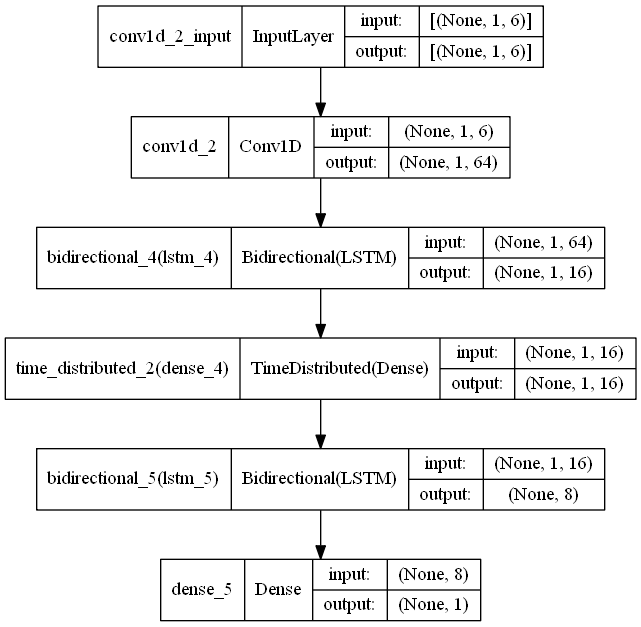

In [42]:
from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint_CL.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=10, batch_size=BATCH_SIZE, validation_data=(valid_data), callbacks=[checkpoint, early_stop])

Epoch 1/10
   8212/Unknown - 263s 32ms/step - loss: 0.3030
Epoch 00001: val_loss improved from inf to 0.23243, saving model to model\tmp_checkpoint_CL.h5
8213/8213 [==============================] - 286s 34ms/step - loss: 0.3030 - val_loss: 0.2324
Epoch 2/10
8212/8213 [============================>.] - ETA: 0s - loss: 0.3030
Epoch 00002: val_loss did not improve from 0.23243
8213/8213 [==============================] - 287s 35ms/step - loss: 0.3029 - val_loss: 0.2427
Epoch 3/10
8212/8213 [============================>.] - ETA: 0s - loss: 0.3030
Epoch 00003: val_loss did not improve from 0.23243
8213/8213 [==============================] - 266s 32ms/step - loss: 0.3030 - val_loss: 0.2333
Epoch 4/10
8213/8213 [==============================] - ETA: 0s - loss: 0.3030
Epoch 00004: val_loss did not improve from 0.23243
8213/8213 [==============================] - 264s 32ms/step - loss: 0.3030 - val_loss: 0.2436


In [44]:
model.load_weights(filename)
pred = model.predict(test_data)
pred.shape

(525600, 1)

### 9. 결과 표시

In [45]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


<function matplotlib.pyplot.show(close=None, block=None)>

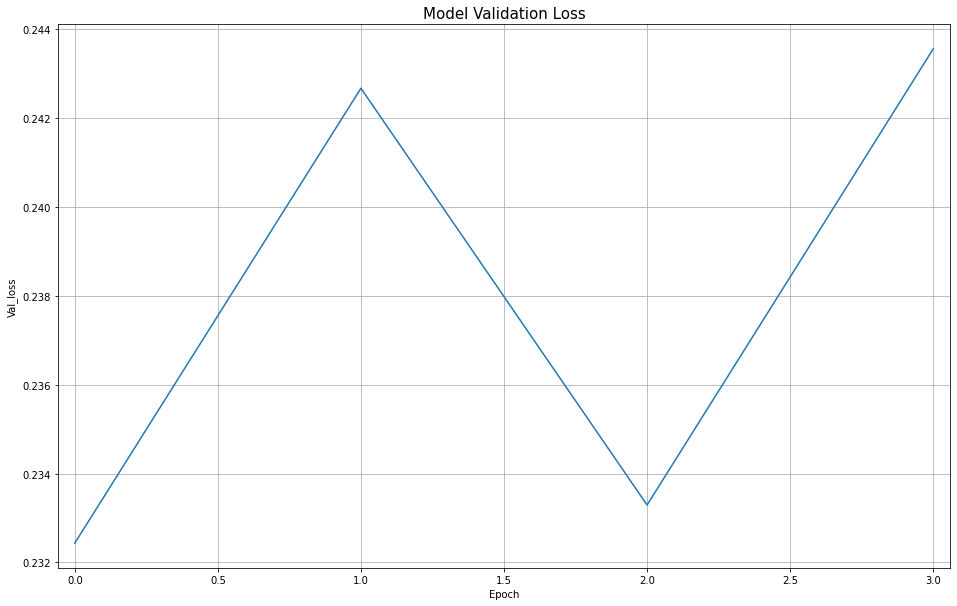

In [46]:
plt.figure(figsize=(16, 10))
plt.title('Model Validation Loss', size='15')
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.margins(x=0.02)
plt.savefig('./Result/CNN+LSTM/Graph/Model_Valdation_Loss.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

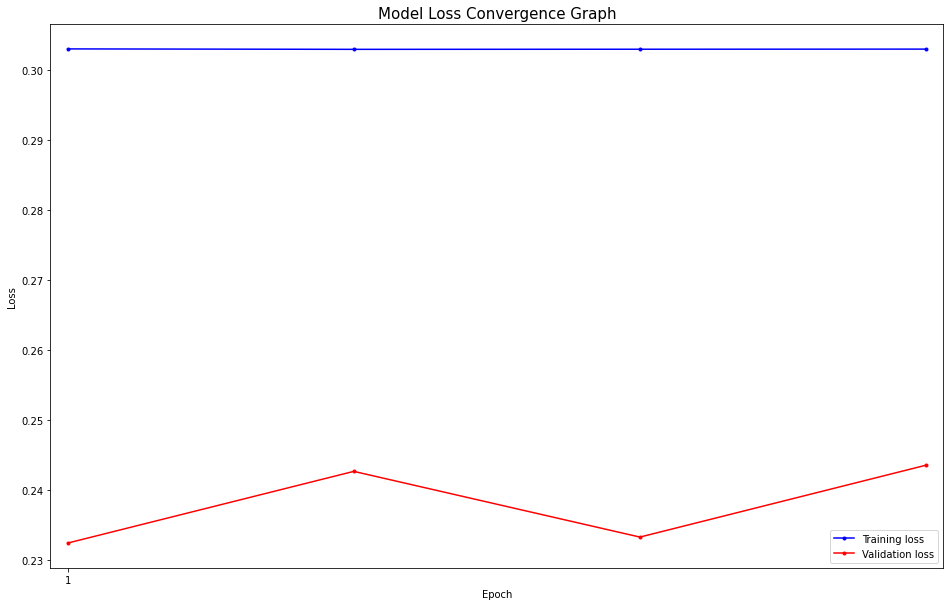

In [47]:
plt.figure(figsize=(16, 10))
plt.title('Model Loss Convergence Graph', size='15')
y_tloss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_tloss))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,200,10), labels=range(1,201, 10))

plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
plt.margins(x=0.02)
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('./Result/CNN+LSTM/Graph/Model_Loss_Convergence_Graph.png')
plt.show

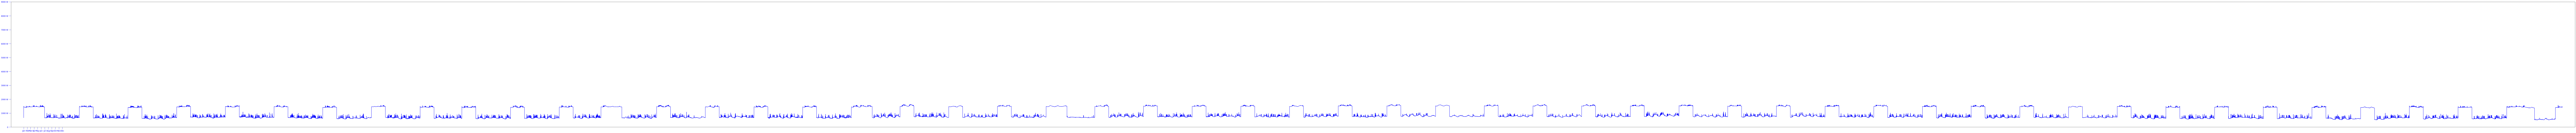

In [48]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='blue', size=15)
plt.tick_params(axis='x', colors='blue', labelsize=12)
plt.tick_params(axis='y', colors='blue', size=15)
plt.tick_params(axis='y', colors='blue', labelsize=12)

plt.plot(pred, label = 'Prediction',color='blue')

plt.xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Prediction.png')
plt.show()

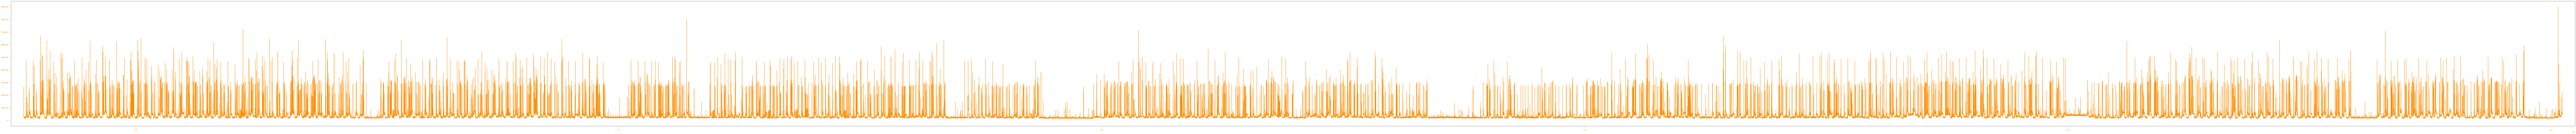

In [49]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='darkorange', size=15)
plt.tick_params(axis='x', colors='darkorange', labelsize=12)
plt.tick_params(axis='y', colors='darkorange', size=15)
plt.tick_params(axis='y', colors='darkorange', labelsize=12)

#x=test['Graph_Date']

plt.plot(TEST['Watt'][:-WINDOW_SIZE], label = 'Actual', color='darkorange')

#plt.xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Actual.png')
plt.show()

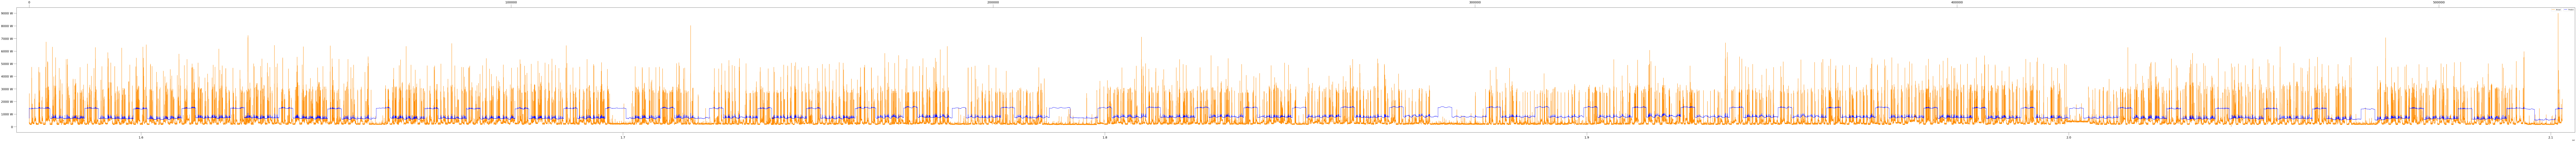

In [50]:
fig = plt.figure(figsize=(300,15)) 
ax1 = fig.add_subplot() # subplot 그래프 생성
ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])

color1 = 'darkorange'
ax1.plot(TEST['Watt'][:-WINDOW_SIZE], color=color1)
#ax1.set_ylabel('y', size=20)
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', size=20, labelsize=20)
ax1.margins(x=0.005)
"""
ax1.set_xticks([26280, 26280+31*24, 26280+59*24, 26280+90*24, 26280+120*24, 26280+151*24, 26280+181*24, 26280+212*24, 26280+243*24, 26280+273*24, 26280+304*24, 26280+334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정
           """
ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.995, 1, 0, 0))

color2 = 'blue'
ax2 = ax1.twiny()
ax2.plot(pred, color=color2)
ax2.tick_params(axis='x', size=20, labelsize=20)
ax2.margins(x=0.005)
"""
ax2.set_xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정
           """
ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))

plt.savefig('./Result/CNN+LSTM/Graph/Pred_with_Actual.png')
plt.show()

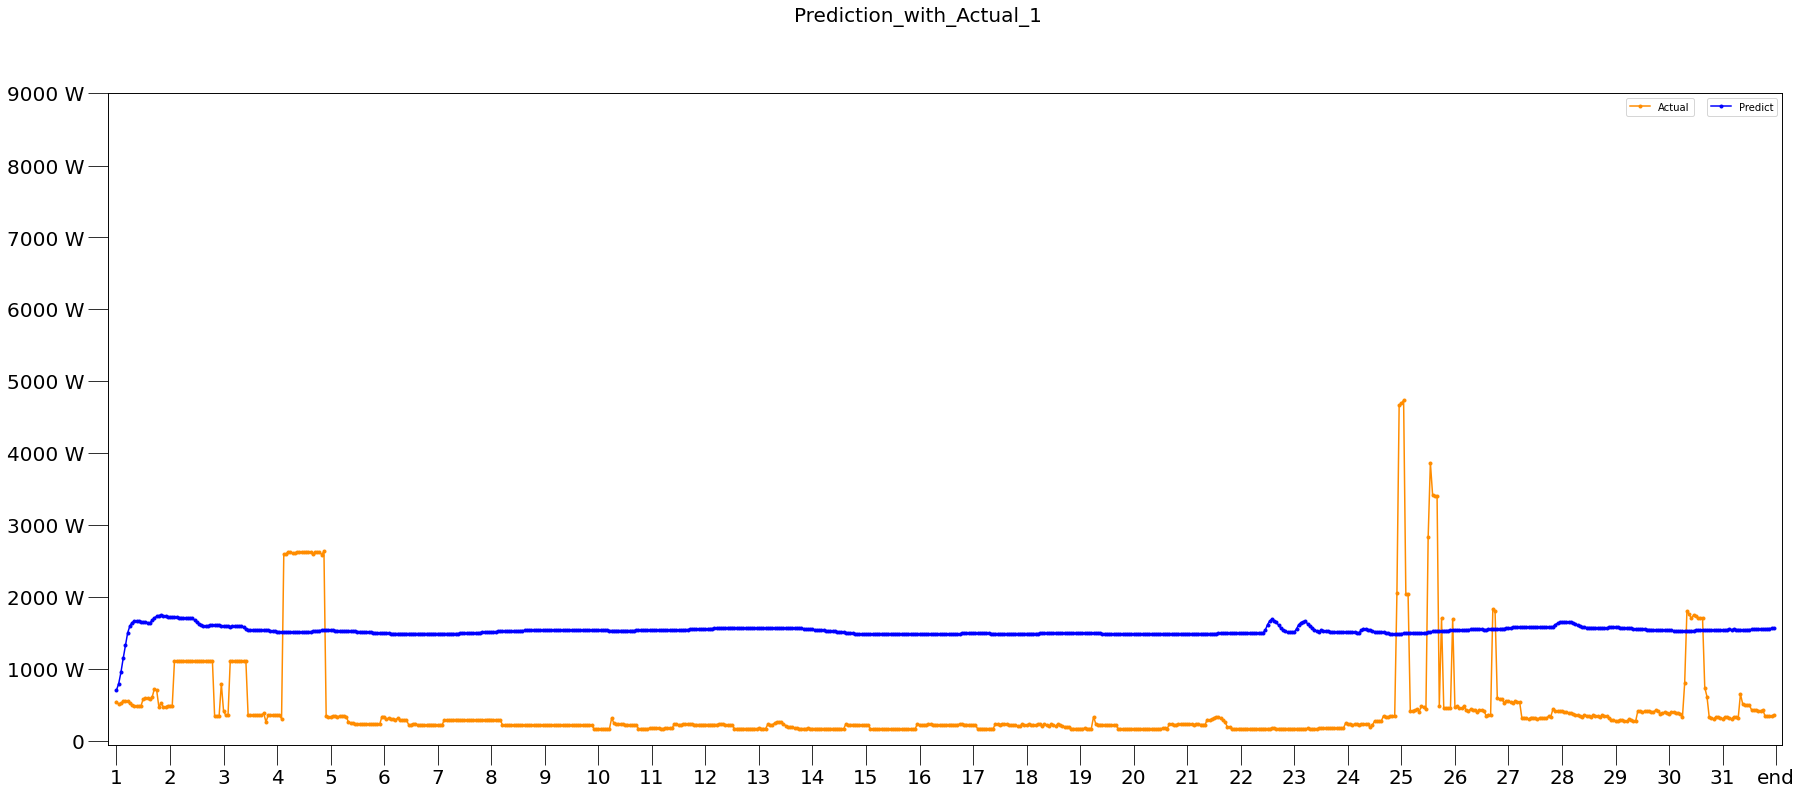

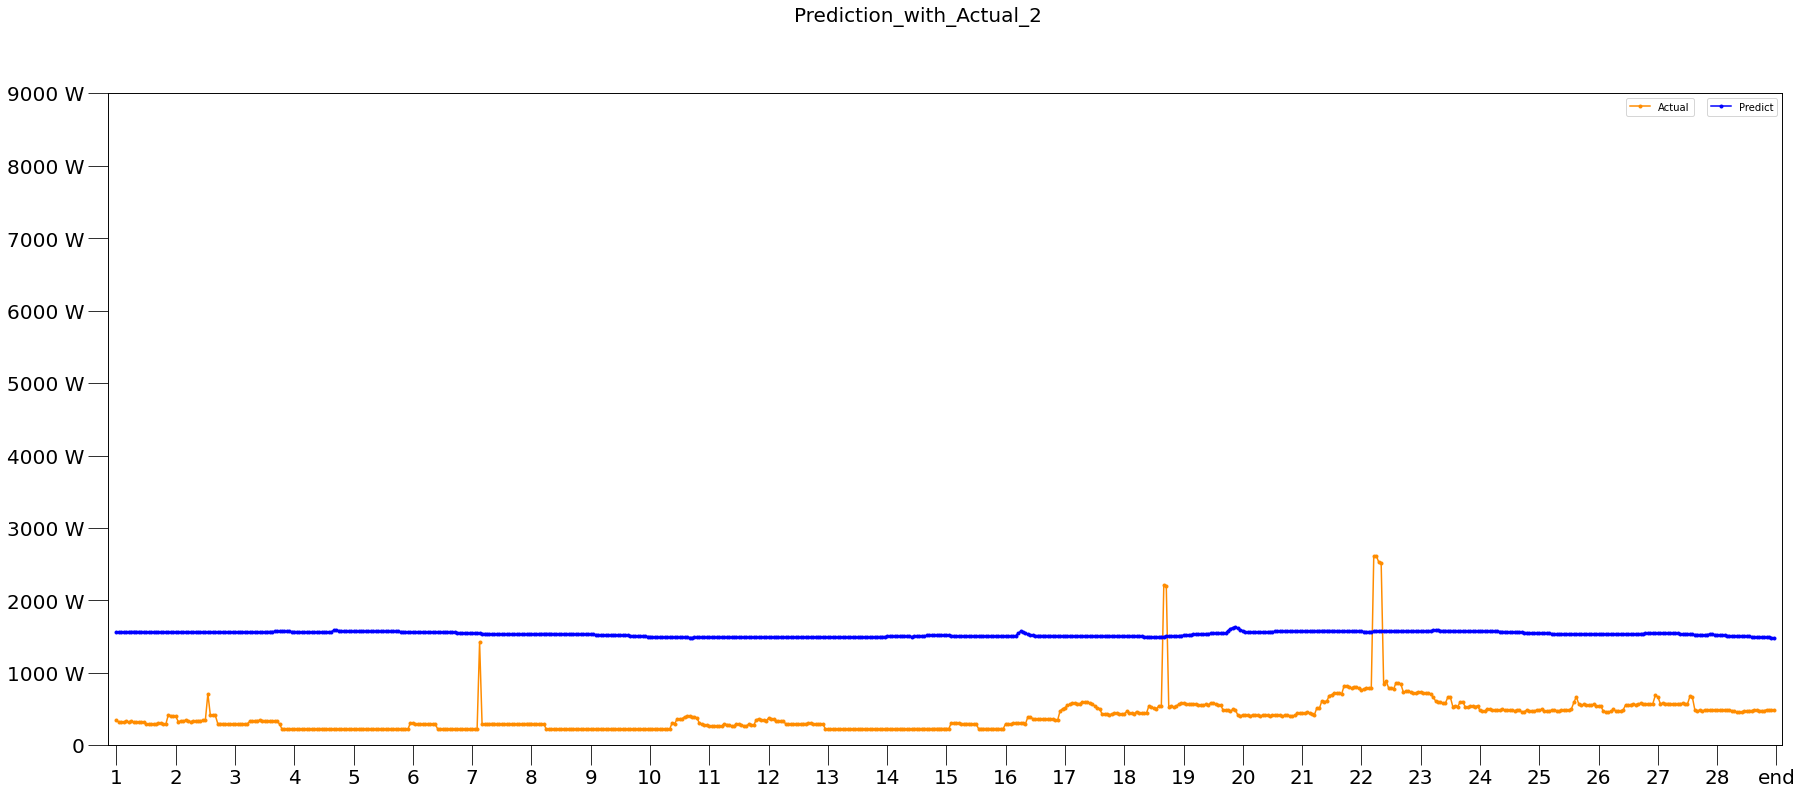

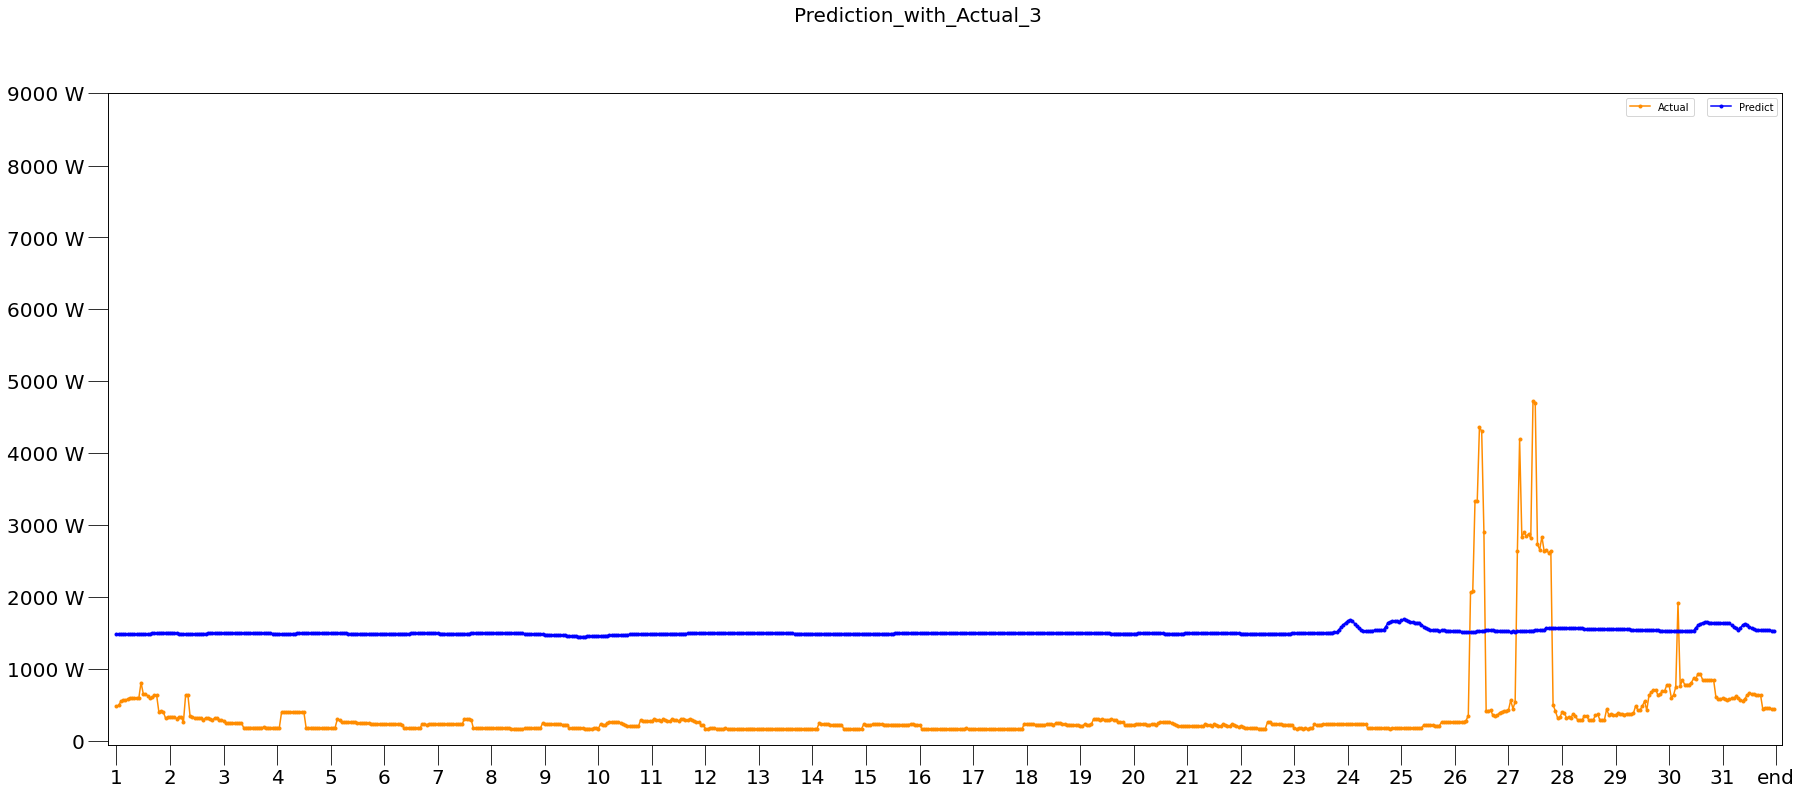

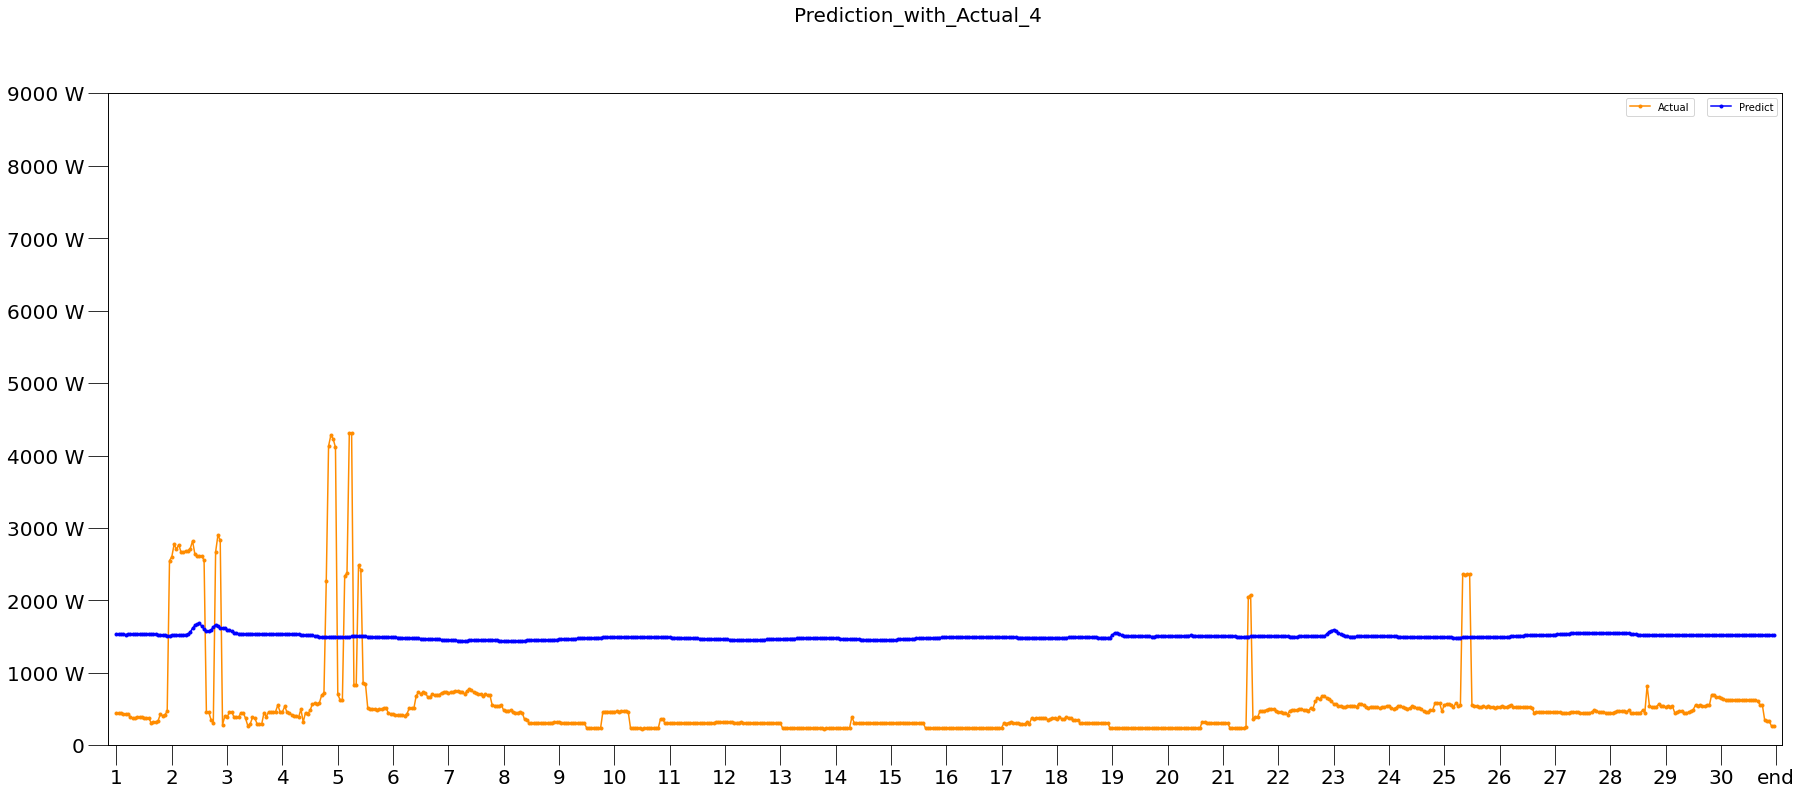

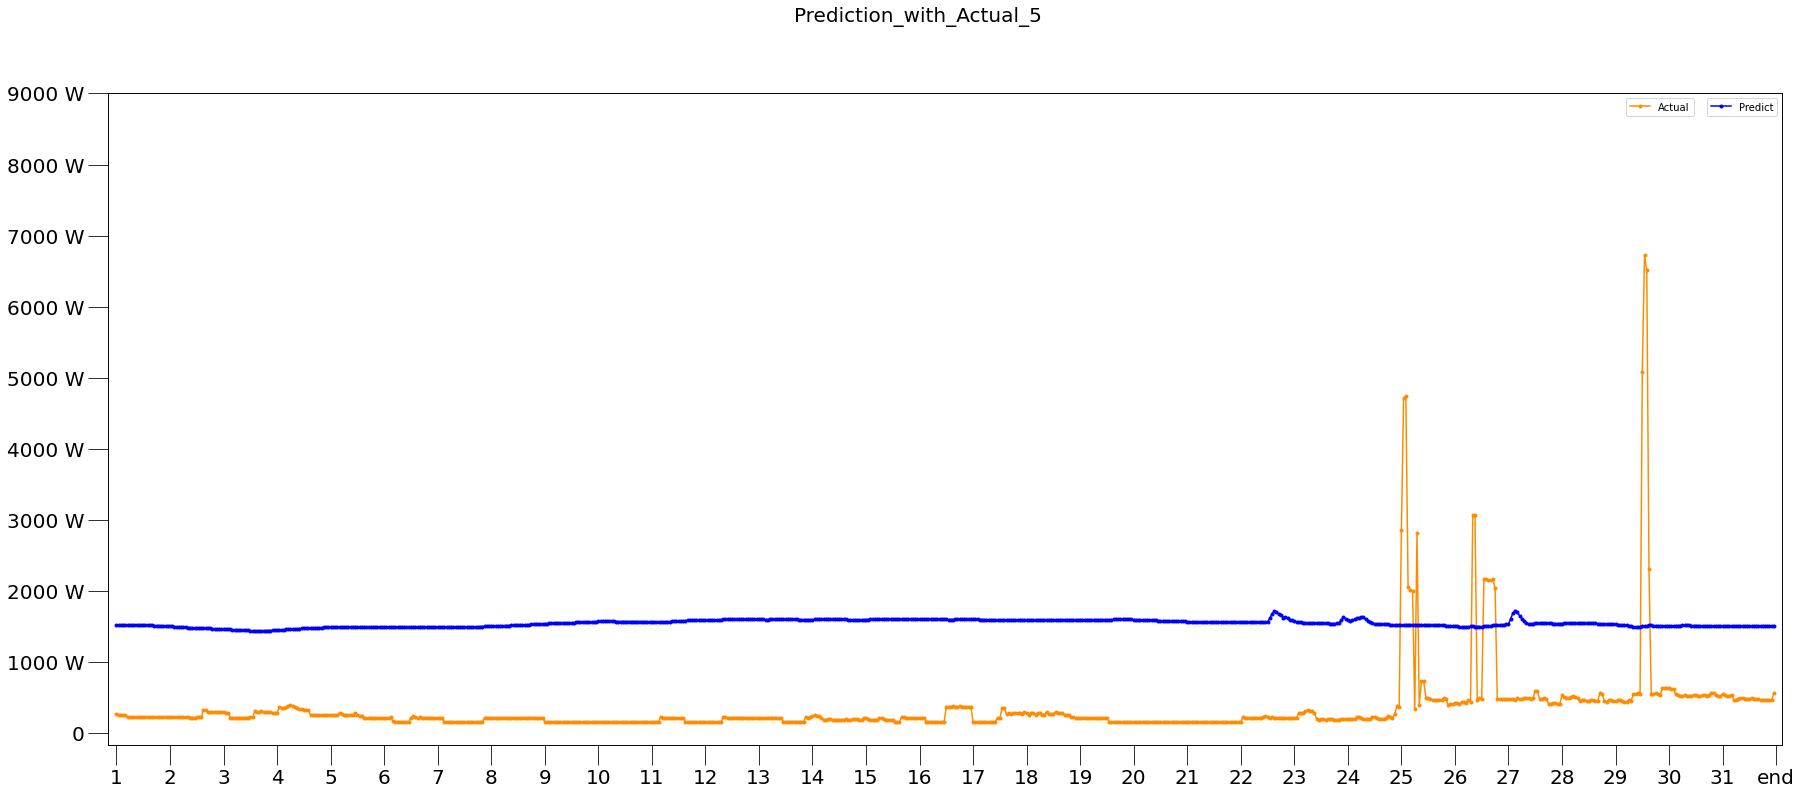

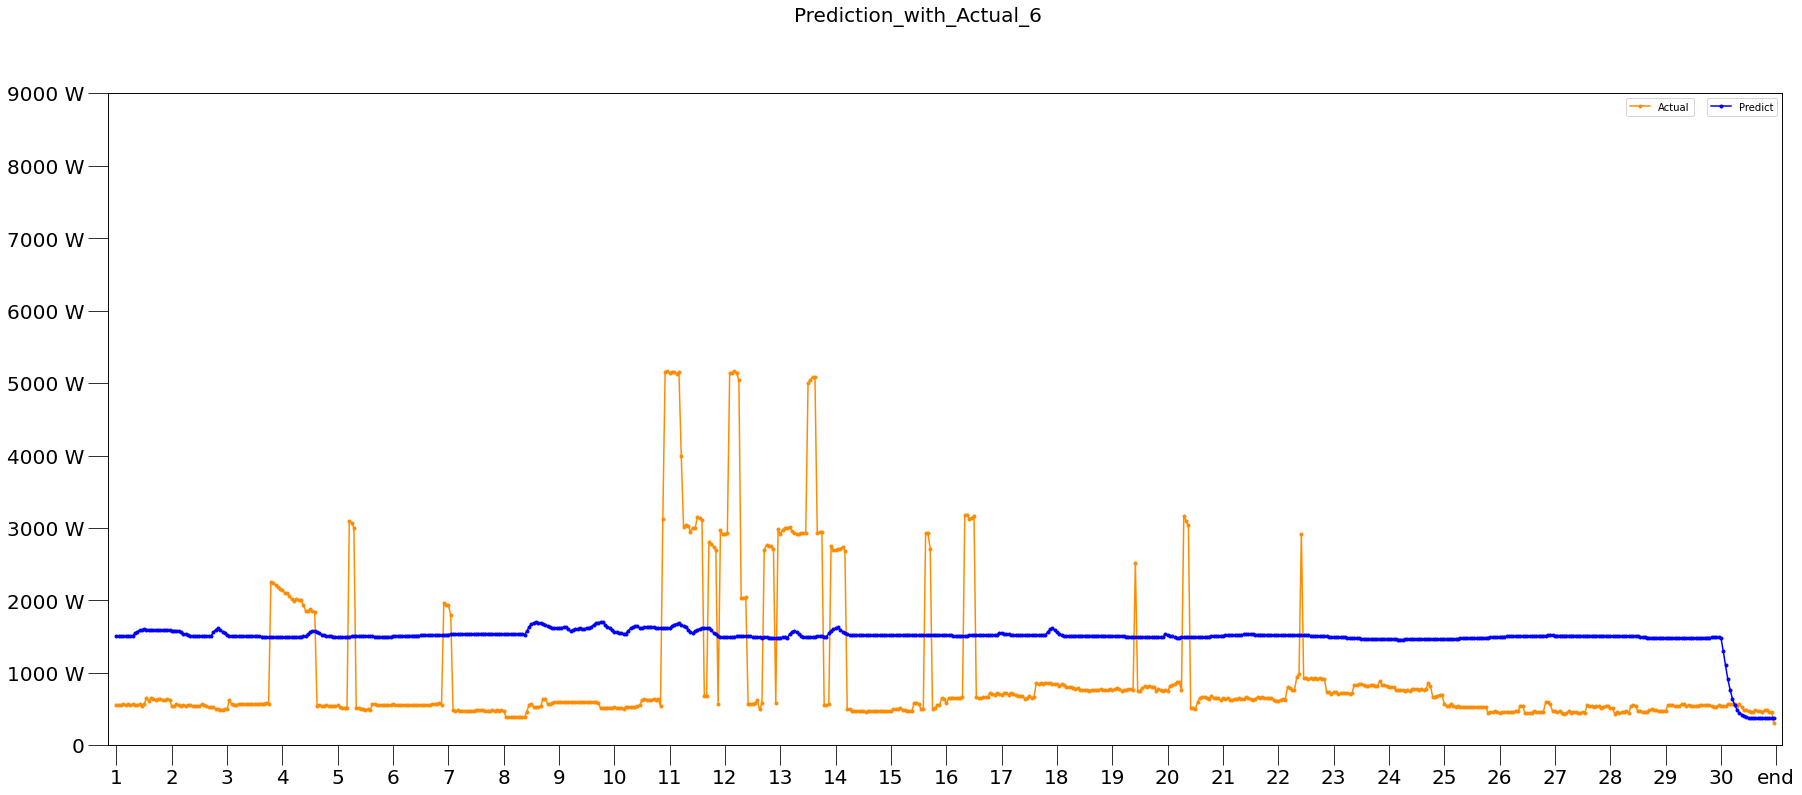

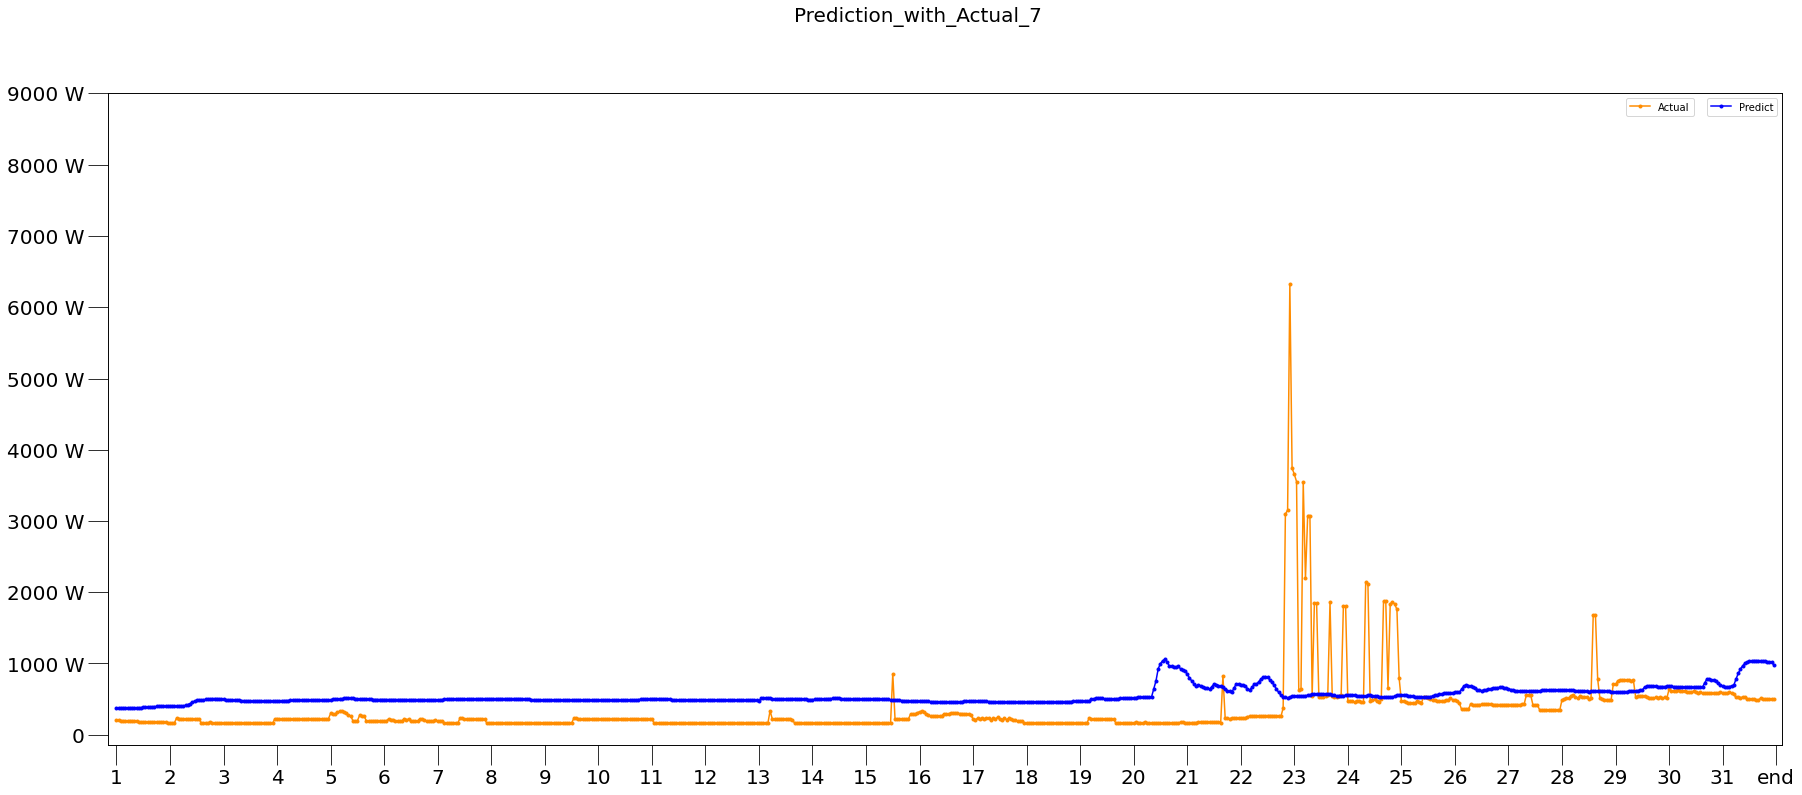

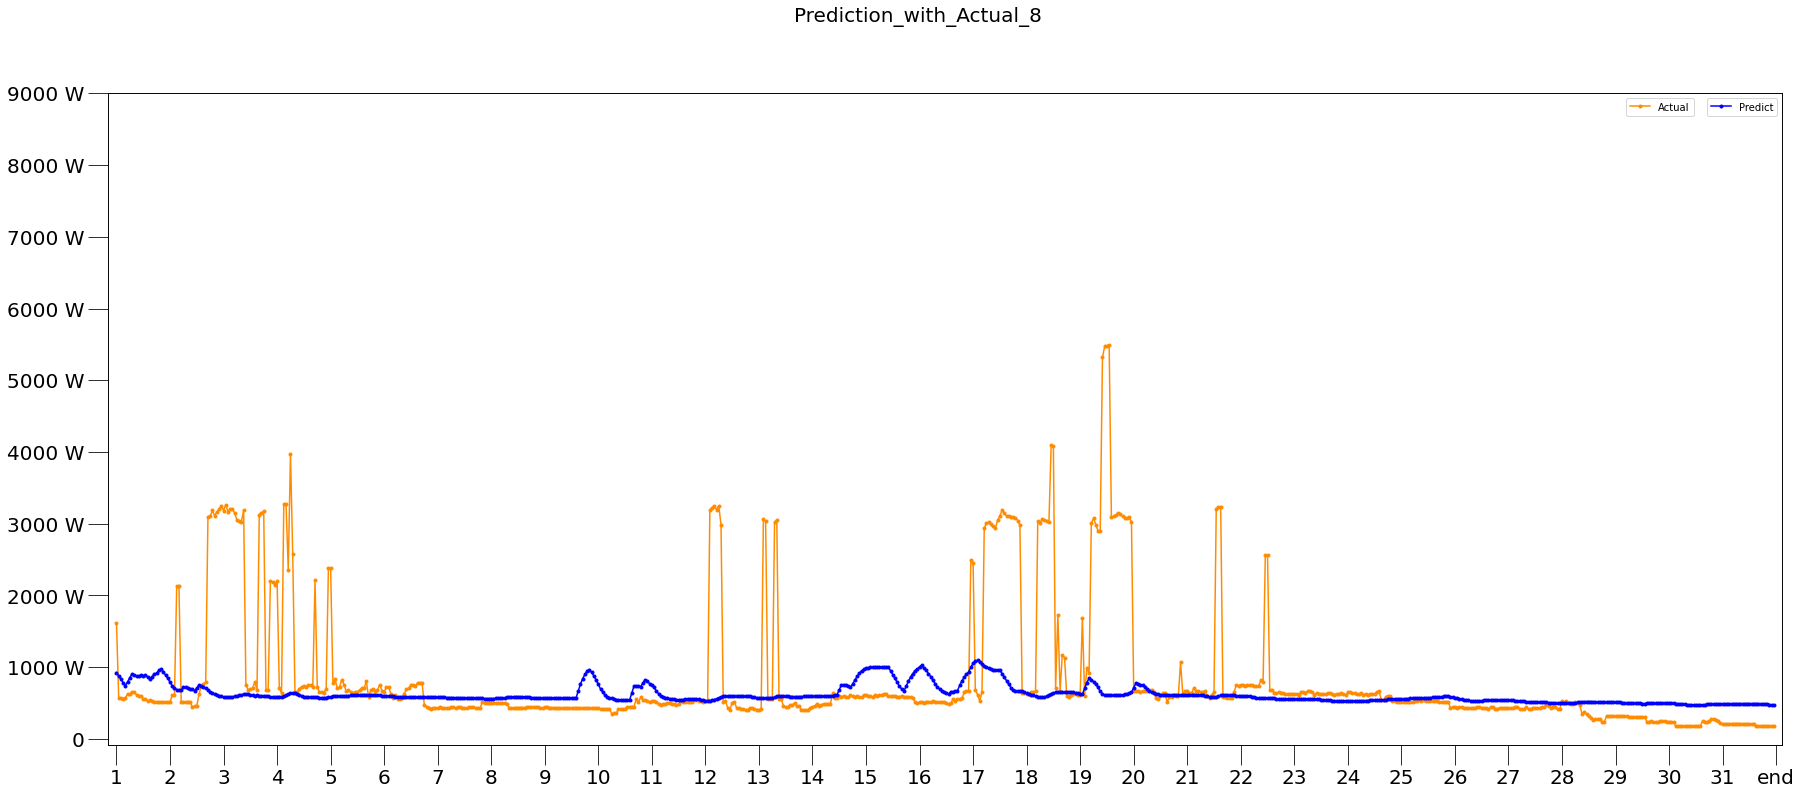

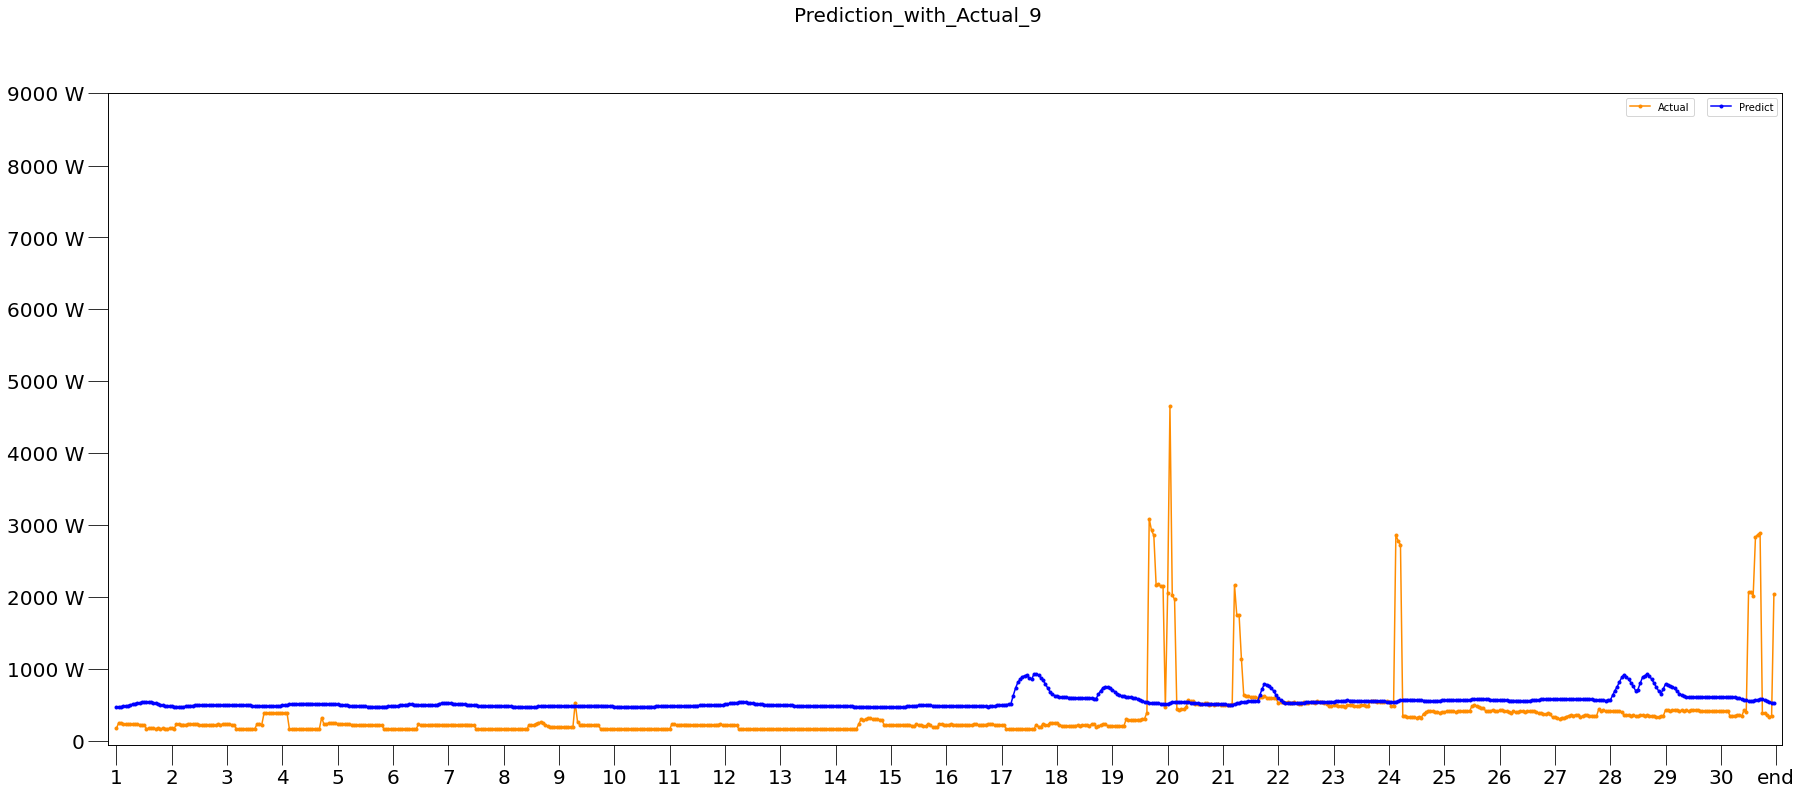

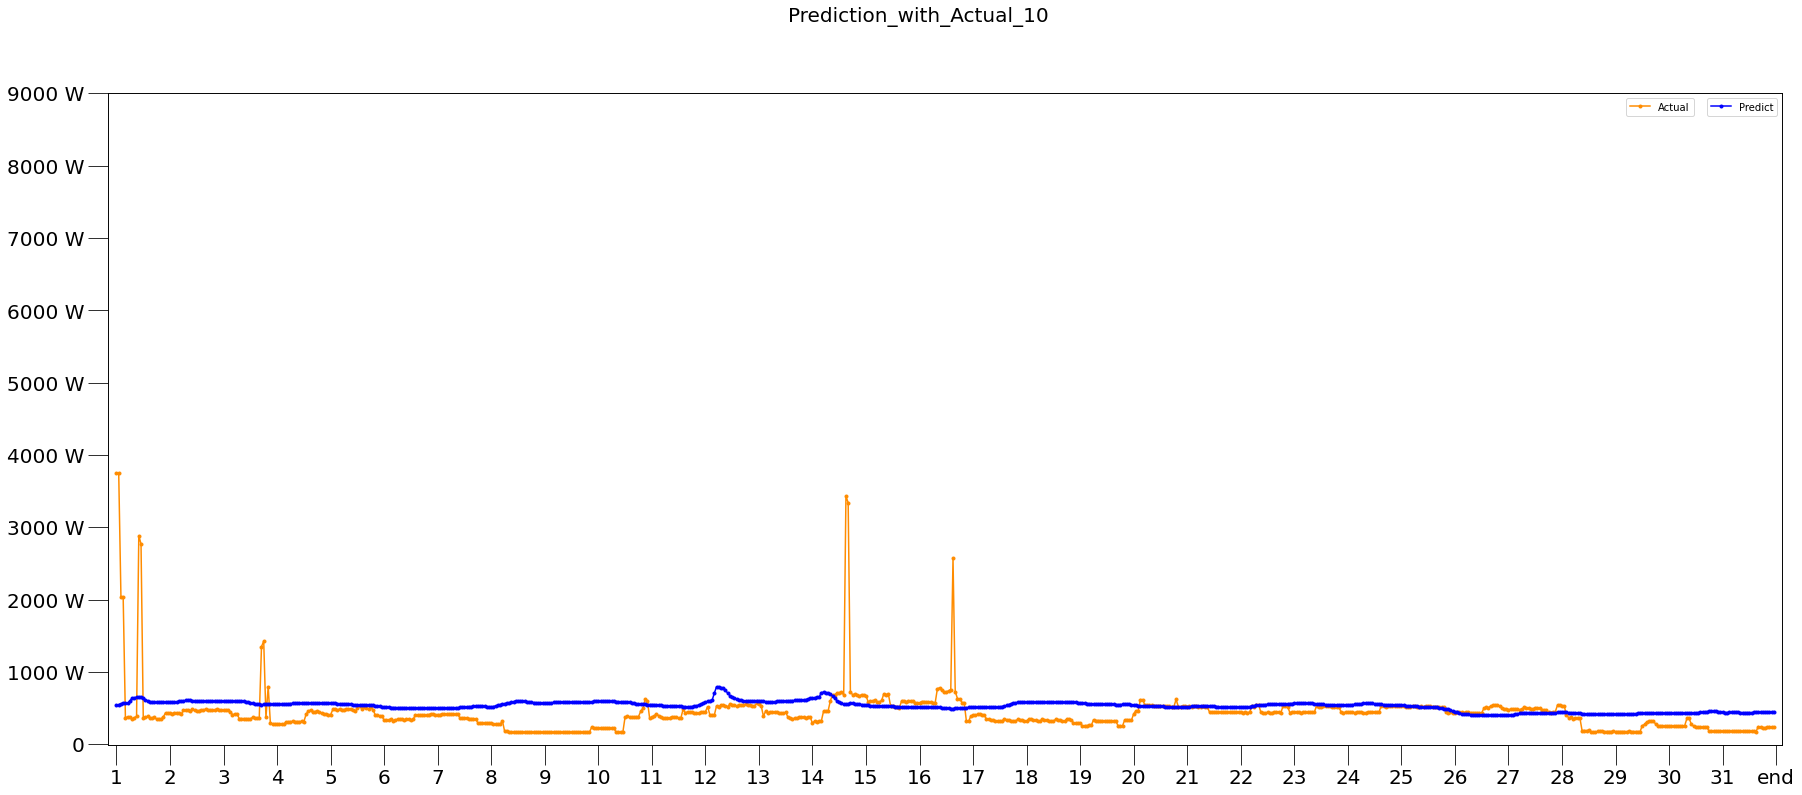

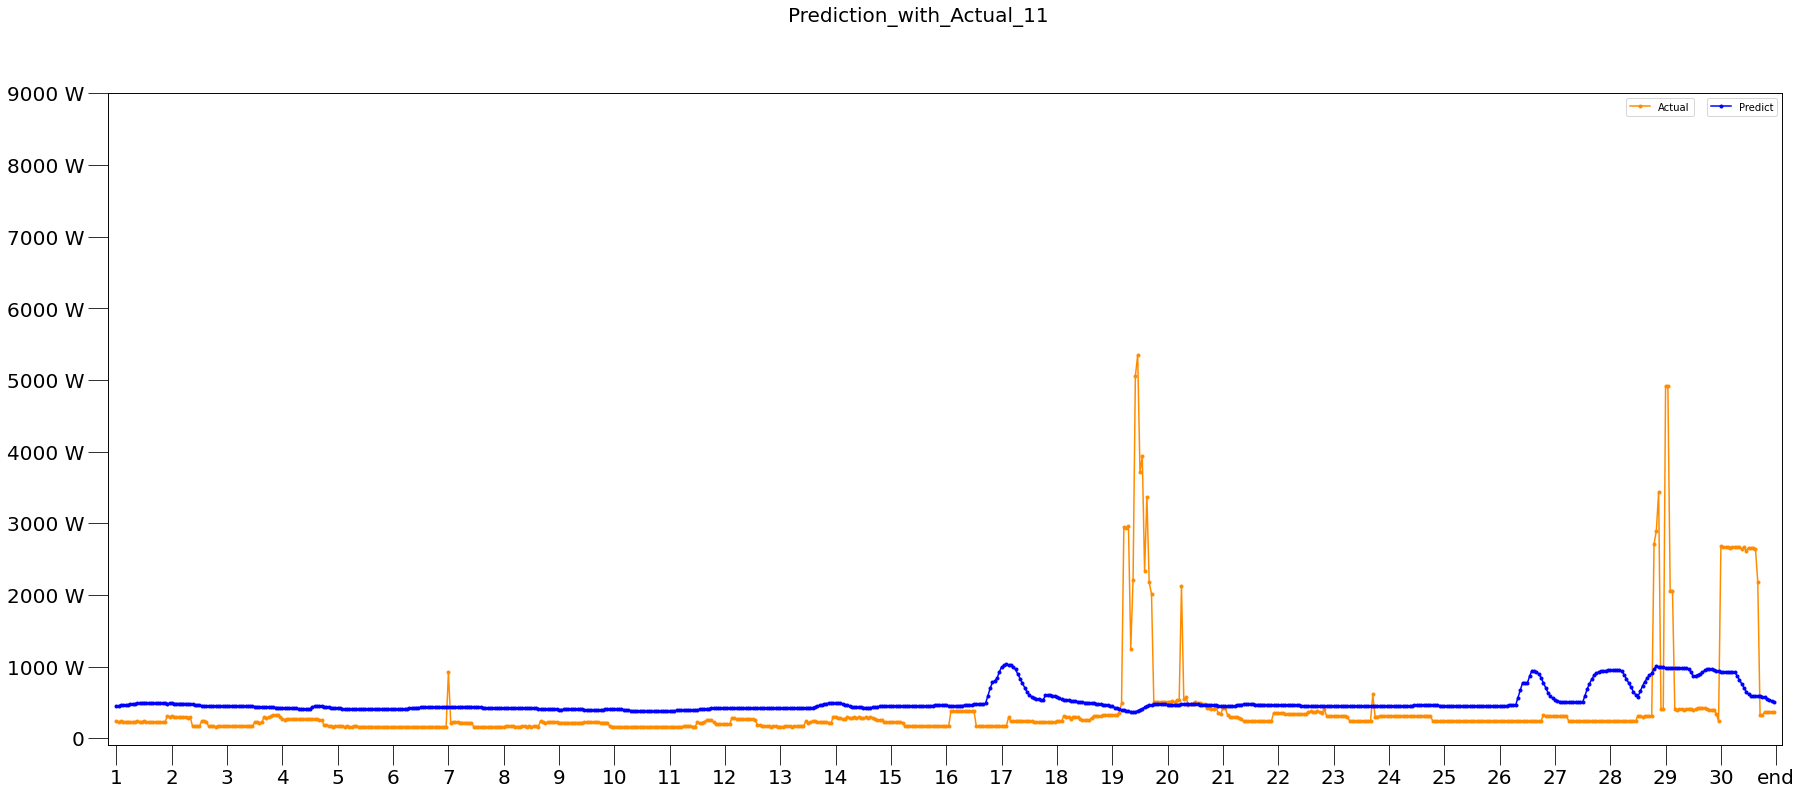

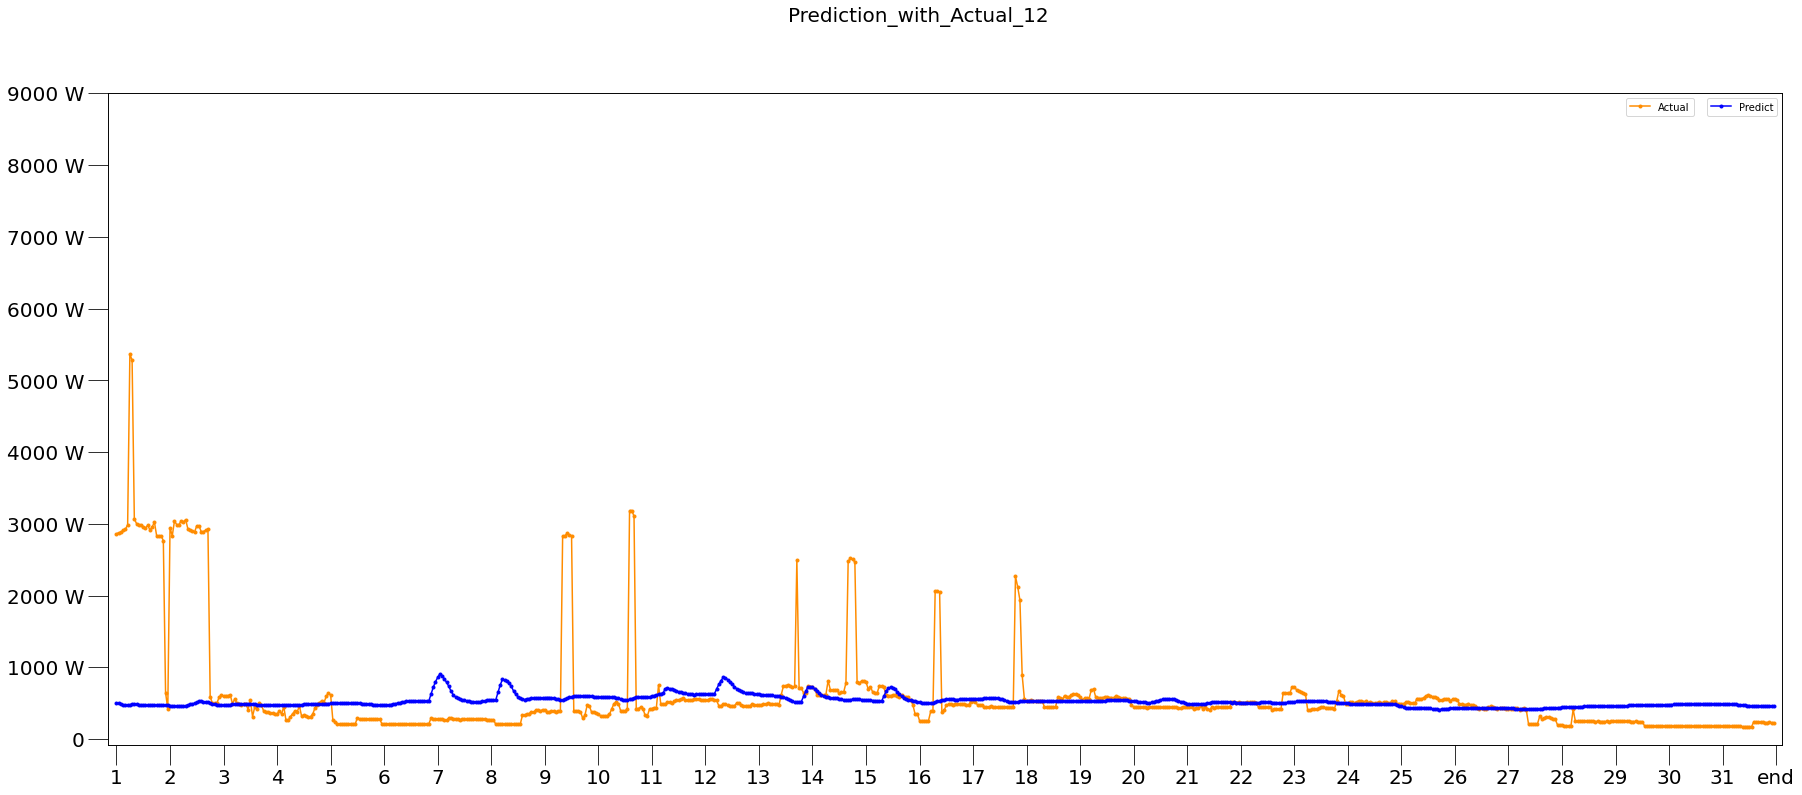

In [21]:
# 월 단위 그래프 분할 표시 및 저장
for m in range(1,13):
    month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    start = {1:0, 2:744, 3:1416, 4:2160, 5:2880, 6:3624, 7:4344, 8:5088, 9:5832, 10:6552, 11:7296, 12:8016}
    end = {1:744, 2:1416, 3:2160, 4:2880, 5:3624, 6:4344, 7:5088, 8:5832, 9:6552, 10:7296, 11:8016, 12:8760}
        
    ax2.set_title('Prediction & Actual Graph - month'+str(m), size='15')
    
    watt_list=TEST['Watt'][:-WINDOW_SIZE].tolist()
    
    fig = plt.figure(figsize=(30,12)) 
    ax1 = fig.add_subplot() # subplot 그래프 생성
    ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
    ax1.set_yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])
    
    # Actual
    color1 = 'darkorange'
    ax1.plot(watt_list[start[m]:end[m]], color=color1, marker='.')
    ax1.tick_params(axis='x', size=20, labelsize=20)
    ax1.margins(x=0.005)
    ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.95, 1, 0, 0))
    
    # Predict
    color2 = 'blue'
    ax2 = ax1.twiny()
    ax2.plot(pred[start[m]:end[m]], color=color2, marker='.')
    ax2.tick_params(axis='x', size=20, labelsize=20)
    ax2.xaxis.set_visible(False)
    ax2.margins(x=0.005)
    ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))
    
    # 월별 xticks 설정 함수
    def xticks_list (days):
        xticks_list=[]
        for x in range(0,days+1):
            xticks_list.append(x*24)
        return xticks_list
    
    # month labels 설정 함수
    def month_labels (days):
        month_labels=[]
        for ml in range(1,days+1):
            month_labels.append(ml)
        month_labels.append('end') 
        return month_labels
    
    if (m==2):
        ax1.set_xticks(xticks_list(28), labels=month_labels(28))

    if (m==4 or m==6  or m==9 or m==11):
        ax1.set_xticks(xticks_list(30), labels=month_labels(30))
        
    if (m==1 or m==3 or m==5 or m==7 or m==8 or m==10 or m==12):
        ax1.set_xticks(xticks_list(31), labels=month_labels(31))
        
    ax1.set_yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])
    
    plt.suptitle('Prediction_with_Actual_'+str(m),fontsize=20)
    plt.grid(True)
    plt.savefig('./Result/CNN+LSTM/Graph/Prediction_with_Actual_'+str(m)+'.png')
    plt.show()

#### 그래프 비교 결과

In [29]:
import cv2
from skimage.metrics import structural_similarity as ssim

In [30]:
# 유사도 측정을 위한 이미지 가공
image1 = cv2.imread('./Result/CNN+LSTM/Graph/Prediction.png')
image2 = cv2.imread('./Result/CNN+LSTM/Graph/Actual.png')

tempDiff1 = cv2.subtract(image1, image2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [31]:
# 차이 추출을 위한 뺄셈 과정
pred_list=pred.tolist()
actual_list=TEST['Watt'][:-WINDOW_SIZE].tolist()

In [32]:
(score, diff) = ssim(gray1, gray2, full=True)
sim_score = round(score,5)*100

print('그래프 유사도 ==>> %.3f %%' %sim_score)

그래프 유사도 ==>> 76.925 %


#### 성능 측정 지표

In [33]:
true = TEST['Watt'][:-WINDOW_SIZE].to_numpy()
true = true.reshape(-1,1)

In [34]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

MAE = MAE(true, pred)
RMSE = np.sqrt(MSE(true, pred))

print('r2 >> %.4f' %r2(true, pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE) # 0에 가까워야 좋음
print('RMSE >> %.4f' %RMSE) # 0에 가까워야 좋음

r2 >> 0.2817
MAE >> 0.1633
RMSE >> 0.2144


In [35]:
MAE_pct = round(1-MAE, 5)*100
RMSE_pct = round(1-RMSE, 5)*100
print('MAE 측정 정확도 ==>> %.3f %%' %MAE_pct)
print('RMSE 측정 정확도 ==>> %.3f %%' %RMSE_pct)

MAE 측정 정확도 ==>> 83.667 %
RMSE 측정 정확도 ==>> 78.562 %
